In [26]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 14

import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten #, Reshape
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D

%run plot.py

### Read data

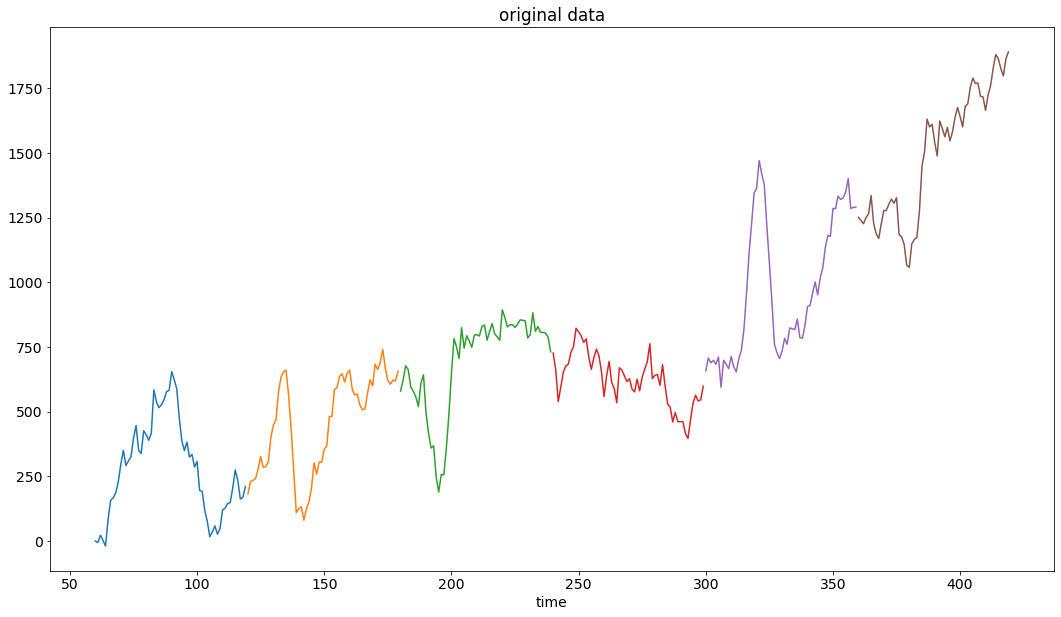

data:  10000


In [27]:
str0 = 'ts_L60_Z12_A500_DX50_bias5_N10000.dat'
fnamex='DATA/x_'+str0
fnamey='DATA/y_'+str0

x = np.loadtxt(fnamex, delimiter=" ",dtype=float)
N,L = len(x), len(x[0])

Show_data(x,L,6,"original data")

categ = np.loadtxt(fnamey, dtype=int)
n_class = 3    # y.argmax() - y.argmin() +1
print('data: ',N)

y = np.zeros((N,n_class))
for i in range(N):
    y[i][categ[i]] = 1.

### Rescale data, split train/val.

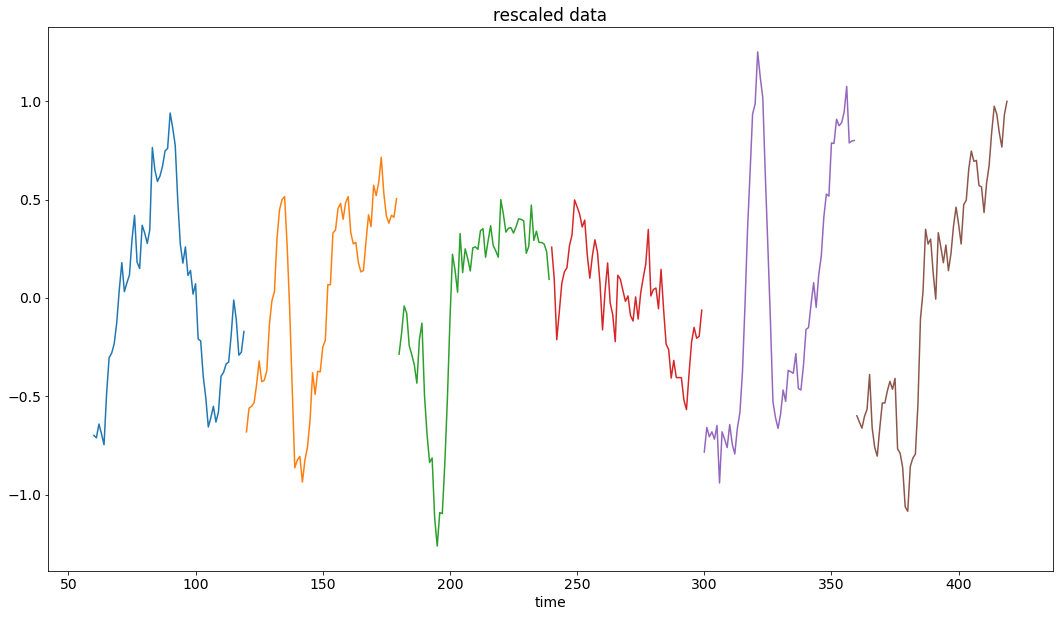

N_train= 8000   N_val= 2000   L= 60   n_class= 3


In [28]:
import numpy as np
import matplotlib.pyplot as plt

def Show_data(x,L,nSamples = 2,title="data"):
    fig = plt.figure(figsize = (nSamples*3,10))
    for i in range(nSamples):
        plt.plot(np.arange((i+1)*L,(i+1)*L+L),x[i])
        #plt.plot(np.arange(L,2*L),x[1])
        #plt.plot(np.arange(2*L,3*L),x[2])
    plt.title(title)
    plt.xlabel("time")
    plt.show()

#
#  FIRST PASSAGE:  DO NOT DO THIS --> FAILURE 
#
#remove average value of each sample from its values
xm = x.mean(axis=1)
for i in range(N):
    x[i] = x[i]-xm[i]

#
#  SECOND PASSAGE:  DO NOT DO THIS --> ALSO FAILURE 
#
#rescale variance
# for i in range(N):
#     x[i] = x[i]/np.var(x[i])

#rescale crude
x = x/400

Show_data(x,L,6,"rescaled data")

perc_train=0.8
N_train = int(perc_train*N)
x_train = x[:N_train]
y_train = y[:N_train]
x_val = x[N_train:]
y_val = y[N_train:]
N_val = len(x_val)
print('N_train=',N_train,'  N_val=',N_val,'  L=',L,'  n_class=',n_class)

#x_train=x_train.astype("float32")
#y_train=y_train.astype("float32")
#x_val=x_val.astype("float32")
#y_val=y_val.astype("float32")

# Keras wants an additional dimension with a 1 at the end
x_train = x_train.reshape(x_train.shape[0], L, 1)
x_val =  x_val.reshape(x_val.shape[0], L, 1)
input_shape = (L, 1)

## Convolutional NN

In [54]:
# ...LESSON ...
# reproducibility
import tensorflow.random as tf_r
def compile_model(regLevel = 0.2):
    np.random.seed(12345)
    
    tf_r.set_seed(12345)
    ## from keras import regularizers, initializers
    reg = tf.keras.regularizers.l1(regLevel) ## raised to 0.2
    #reg = regularizers.l1(0.1)
    ini = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05,seed=None)
    model = Sequential()
    # -----2-- Convelutional layers
    model.add(Conv1D(filters=NF, kernel_size=11, 
                     kernel_initializer=ini, 
                     kernel_regularizer=reg,
                     activation='relu', 
                     input_shape=input_shape))
    #model.add(MaxPooling1D(3))
    model.add(AveragePooling1D(5))
    model.add(Conv1D(filters=5, kernel_size=7, 
                     activation='relu'))
    model.add(Flatten())
    model.add(Dense(12, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(n_class, activation='softmax')) # softmax !
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
    return model

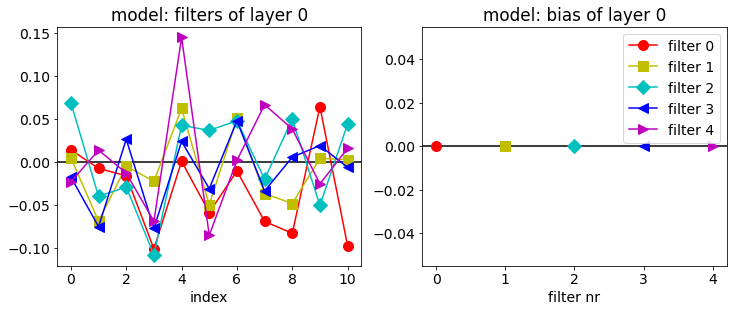

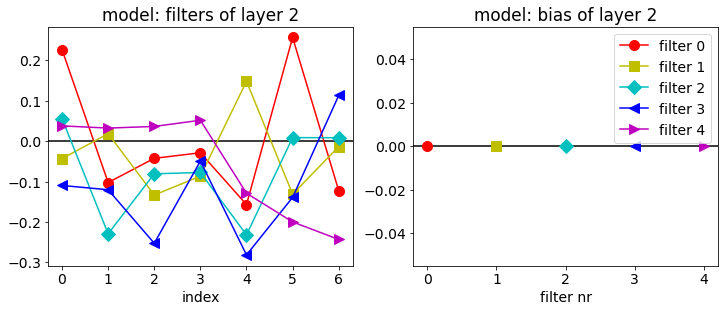

In [32]:
def Show_weights(model,l=0,label="model"):
    c=['r','y','c','b','m']
    m=['o','s','D','<','>']
    ms=10
    
    w = model.layers[l].get_weights()[0]
    wT=w.T
    M=len(wT)
    b = model.layers[l].get_weights()[1]
    
    fig,AX=plt.subplots(1,2,figsize=(12,4.4))
    ax=AX[0]
    ax.axhline(0, c="k")
    ax.plot((0,))
    for i in range(M):
        ax.plot(wT[i][0],"-",c=c[i],marker=m[i],label=str(i),markersize=ms)
    ax.set_title(label+': filters of layer '+str(l))
    ax.set_xlabel('index')
    ax=AX[1]
    ax.axhline(0, c="k")
    for i in range(M):
        ax.plot((i),(b[i]),c=c[i],marker=m[i],label="filter "+str(i),markersize=ms)
    ax.set_title(label+': bias of layer '+str(l))
    ax.set_xlabel('filter nr')
    ax.set_xticks(np.arange(5))
    ax.legend()
    plt.show()
    
Show_weights(model,0)
Show_weights(model,2)

# Daniel's Regularisation Investigation

In [57]:
import os
# ...LESSON ...
# Hyper-parameters
# with small minibatch it does not converge!! 


BATCH_SIZE = 250
EPOCHS = 100

#used to retain best weights when training
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = os.getcwd(),
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose = 0)

accTrain = []
accVal = []
regLevels = np.linspace(0,0.1,10)#np.array([0.1,0.001,1e-5,0])#
for regLevel in regLevels:
    compile_model(regLevel)
    fit = model.fit(x_train,y_train,batch_size=BATCH_SIZE,
                epochs=EPOCHS,
                validation_data=(x_val, y_val),
                verbose=0, shuffle=True,callbacks=[model_checkpoint_callback])
    accTrain.append(np.max(fit.history['accuracy']))
    accVal.append(np.max(fit.history['val_accuracy']))

INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/03_convol/assets
INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/03_convol/assets
INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/03_convol/assets
INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/03_convol/assets
INFO:tensorflow:Assets written to: /home/daniel/CompLabB/CompLabB-UNIPD-TeamDream/Daniel/03_convol/assets


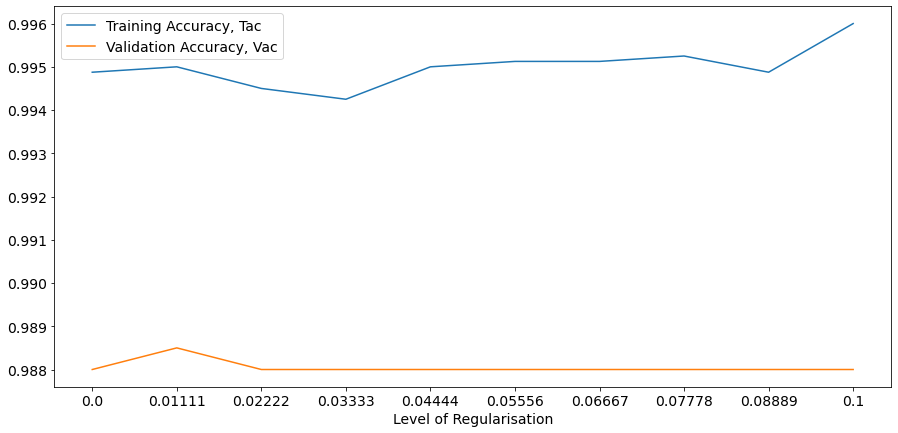

In [58]:
regFig = plt.figure(figsize = (15,7))
plt.plot(accTrain, label = 'Training Accuracy, Tac')
plt.plot(accVal, label = 'Validation Accuracy, Vac')
#plt.plot(np.array(accTrain)-np.array(accVal), label = 'Overfitting Level, Tac - Vac')
plt.xlabel('Level of Regularisation')
plt.xticks(range(len(regLevels)),np.round(regLevels,5))
plt.legend()


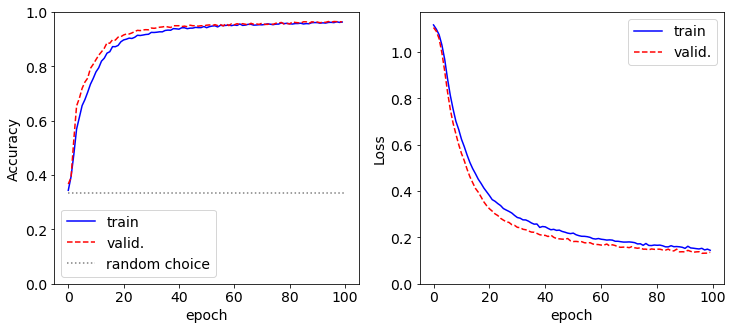

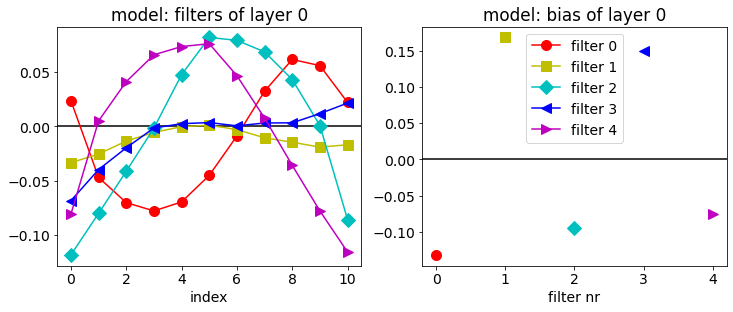

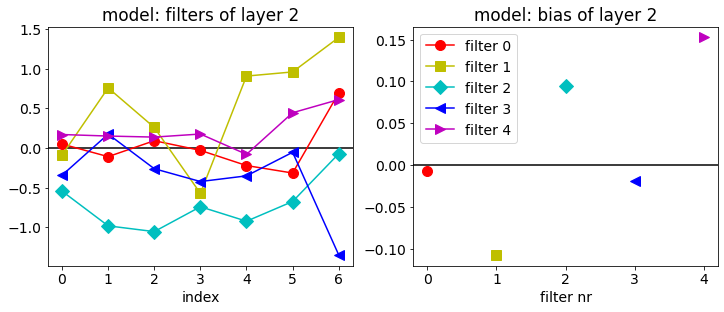

In [34]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.plot(fit.history['val_accuracy'],"r--",label="valid.")
    ax.plot((0,EPOCHS),(1/3,1/3),":",c="gray",label="random choice")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.set_ylim([0, 1])
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.plot(fit.history['val_loss'],"r--",label="valid.")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()
Show_history(fit)
Show_weights(model,0)
Show_weights(model,2)

In [35]:
# ...LESSON ...
reg2 = tf.keras.regularizers.l1(0.5)
model2 = keras.models.clone_model(model)
model2.layers[0].kernel_regularizer = reg2
model2.layers[2].kernel_regularizer = reg2
model2.compile(loss=keras.losses.categorical_crossentropy,optimizer=opt,metrics=['accuracy'])

BATCH_SIZE2 = 250
EPOCHS2 = 100

fit2 = model2.fit(x_train,y_train,batch_size=BATCH_SIZE2,epochs=EPOCHS2,
                validation_data=(x_val, y_val), verbose=2, shuffle=True) 

Epoch 1/100
32/32 - 2s - loss: 1.0674 - accuracy: 0.4364 - val_loss: 0.9576 - val_accuracy: 0.6285 - 2s/epoch - 60ms/step
Epoch 2/100
32/32 - 0s - loss: 0.8390 - accuracy: 0.6908 - val_loss: 0.7006 - val_accuracy: 0.7915 - 489ms/epoch - 15ms/step
Epoch 3/100
32/32 - 0s - loss: 0.6359 - accuracy: 0.7889 - val_loss: 0.5214 - val_accuracy: 0.8545 - 465ms/epoch - 15ms/step
Epoch 4/100
32/32 - 0s - loss: 0.5069 - accuracy: 0.8505 - val_loss: 0.4286 - val_accuracy: 0.8880 - 460ms/epoch - 14ms/step
Epoch 5/100
32/32 - 1s - loss: 0.4229 - accuracy: 0.8829 - val_loss: 0.3533 - val_accuracy: 0.9075 - 605ms/epoch - 19ms/step
Epoch 6/100
32/32 - 0s - loss: 0.3713 - accuracy: 0.9050 - val_loss: 0.3057 - val_accuracy: 0.9250 - 480ms/epoch - 15ms/step
Epoch 7/100
32/32 - 0s - loss: 0.3262 - accuracy: 0.9170 - val_loss: 0.2786 - val_accuracy: 0.9330 - 497ms/epoch - 16ms/step
Epoch 8/100
32/32 - 0s - loss: 0.3027 - accuracy: 0.9268 - val_loss: 0.2548 - val_accuracy: 0.9395 - 470ms/epoch - 15ms/step
Epo

Epoch 67/100
32/32 - 0s - loss: 0.0964 - accuracy: 0.9800 - val_loss: 0.0875 - val_accuracy: 0.9825 - 489ms/epoch - 15ms/step
Epoch 68/100
32/32 - 0s - loss: 0.0943 - accuracy: 0.9811 - val_loss: 0.0856 - val_accuracy: 0.9835 - 473ms/epoch - 15ms/step
Epoch 69/100
32/32 - 0s - loss: 0.0958 - accuracy: 0.9800 - val_loss: 0.0836 - val_accuracy: 0.9825 - 440ms/epoch - 14ms/step
Epoch 70/100
32/32 - 0s - loss: 0.0907 - accuracy: 0.9797 - val_loss: 0.0839 - val_accuracy: 0.9825 - 466ms/epoch - 15ms/step
Epoch 71/100
32/32 - 1s - loss: 0.0947 - accuracy: 0.9793 - val_loss: 0.0803 - val_accuracy: 0.9845 - 633ms/epoch - 20ms/step
Epoch 72/100
32/32 - 1s - loss: 0.0932 - accuracy: 0.9812 - val_loss: 0.0848 - val_accuracy: 0.9820 - 567ms/epoch - 18ms/step
Epoch 73/100
32/32 - 0s - loss: 0.0929 - accuracy: 0.9796 - val_loss: 0.0817 - val_accuracy: 0.9815 - 470ms/epoch - 15ms/step
Epoch 74/100
32/32 - 0s - loss: 0.0918 - accuracy: 0.9806 - val_loss: 0.0795 - val_accuracy: 0.9850 - 485ms/epoch - 15

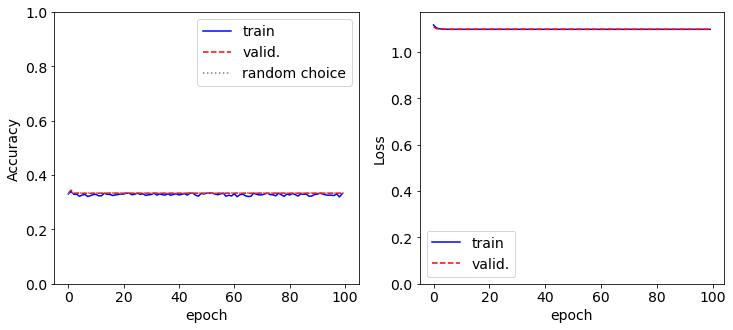

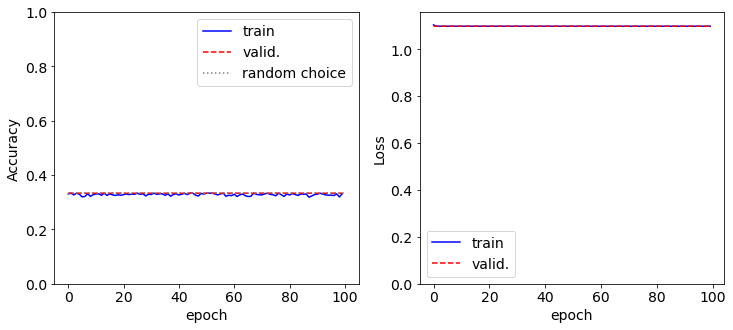

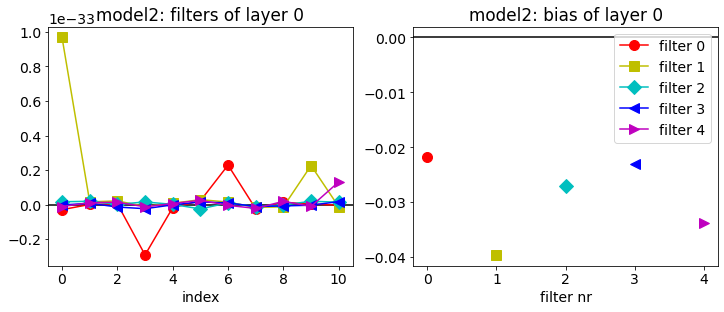

IndexError: list index out of range

In [24]:
Show_history(fit)
Show_history(fit2)
Show_weights(model2,0,label="model2")
Show_weights(model2,2,label="model2")

In [25]:
import pandas as pd
from scipy import stats

import seaborn 
from sklearn import metrics

from sklearn.metrics import classification_report
from sklearn import preprocessing

LABELS = ["absent","positive","negative"]
cmap="GnBu"

def show_confusion_matrix(validations, predictions, label="Model"):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 5))
    seaborn.heatmap(matrix,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d',
                linecolor='white',
                linewidths=1,
                cmap=cmap)
    plt.title(label+': Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_val = model.predict(x_val)
y_pred_val2 = model2.predict(x_val)
# Take the class with the highest probability from the val predictions
max_y_pred_val = np.argmax(y_pred_val, axis=1)
max_y_val = np.argmax(y_val, axis=1)
max_y_pred_val2 = np.argmax(y_pred_val2, axis=1)

show_confusion_matrix(max_y_val, max_y_pred_val)
show_confusion_matrix(max_y_val, max_y_pred_val2, label="Model 2")

#print(classification_report(max_y_val, max_y_pred_val))

ModuleNotFoundError: No module named 'sklearn'